In [1]:
NAME = 'Ahmed Hanif - 60301085'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats
import numpy as np
import re

from quantile_forest import RandomForestQuantileRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,  precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.svm import SVC

<b> Functions Utilized</b>

In [3]:
def calculate_bin_edges(column, bin_boundary):
    return np.arange(0,column.max() + bin_boundary, bin_boundary)

def normalize(x, condition = False):
    return (x - x.min()) / (x.max() - x.min())

def denormalize(original, normalized):
    return normalized * (original.max() - original.min()) + original.min() # (TracyRenee, n.d.)
def logtrans(x, inverse= False):
    if inverse == False:
        return np.log(x)
    elif inverse == True:
        return np.power(2,x)

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df['column'].quantile(0.25)
        Q3 = df['column'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

In [4]:
df_verOne = pd.read_csv('Breast_Cancer-Winter2024.csv')
df_verOne.columns = df_verOne.columns.str.replace(' ','_').str.lower()
df_verOne.rename(columns = {'t_stage_' : 't_stage', 'reginol_node_positive': 'regional_node_positive', '6th_stage': 'sixth_stage'}, inplace = True)
print('Number Of Rows:',df_verOne.shape[0])
print('Duplicated Rows:', df_verOne.duplicated().sum())
df_verOne.drop_duplicates(inplace=True)
df_verOne.sample(50)

Number Of Rows: 4024
Duplicated Rows: 1


,age,race,marital_status,t_stage,n_stage,sixth_stage,differentiate,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status
3679,40,White,Married,T1,N2,IIIA,Moderately differentiated,2,Regional,15.0,Positive,Positive,12,6,60.0,Alive
3110,40,Other,Married,T3,N1,IIIA,Poorly differentiated,3,Regional,100.0,Positive,Negative,18,1,81.0,Alive
3714,60,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,44.0,Positive,Positive,11,7,58.0,Alive
3882,69,White,Widowed,T2,N3,IIIC,Well differentiated,1,Regional,33.0,Positive,Positive,20,19,76.0,Alive
282,50,White,Married,T2,N3,IIIC,Poorly differentiated,3,Regional,25.0,Positive,Negative,18,10,34.0,Dead
3307,66,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,23.0,Positive,Positive,6,1,89.0,Alive
3277,47,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,20.0,Positive,Negative,2,2,27.0,Dead
1899,43,Black,Single,T2,N1,IIB,Poorly differentiated,3,Regional,39.0,Positive,Positive,27,3,69.0,Alive
3102,49,Other,Married,T1,N2,IIIA,Poorly differentiated,3,Regional,20.0,Positive,Positive,27,5,21.0,Dead
124,53,Other,Married,T1,N1,IIA,Well differentiated,1,Regional,15.0,Positive,Positive,23,2,49.0,Alive


<b>Q1 - a - Distribution of Death Event cases among patients and race</b>

In [5]:
total_count_of_each_race = df_verOne['race'].value_counts()
print(total_count_of_each_race)

race
White    3412
Other     320
Black     291
Name: count, dtype: int64


In [6]:
death_count_of_each_race = df_verOne['race'][df_verOne['status'] == 'Dead'].value_counts()
print(death_count_of_each_race)

race
White    510
Black     73
Other     33
Name: count, dtype: int64


In [7]:
total_death_cases = (df_verOne['status'] == 'Dead').sum()
print(total_death_cases)

616


In [8]:
death_percentage_of_each_race = round((death_count_of_each_race / total_death_cases) * 100,2)
print(death_percentage_of_each_race)

race
White    82.79
Black    11.85
Other     5.36
Name: count, dtype: float64


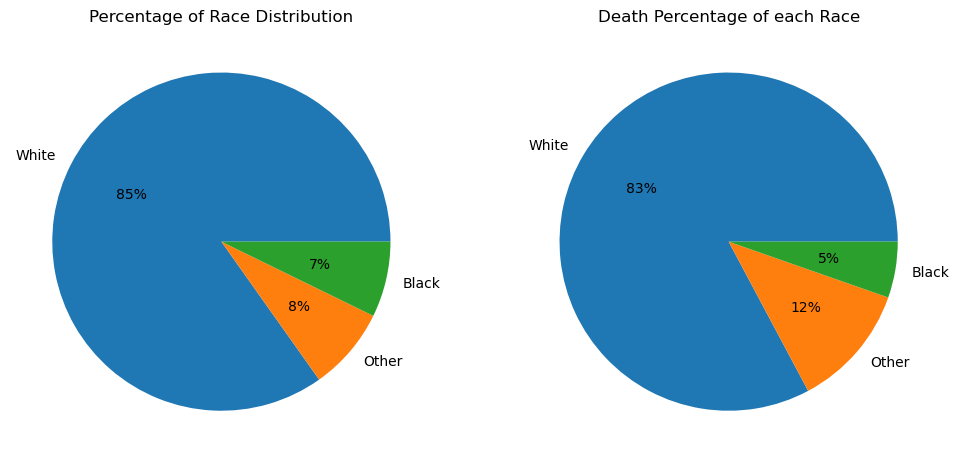

In [9]:
plt.figure(figsize=(12,8));
plt.subplot(1,2,1)
plt.pie(total_count_of_each_race, labels = df_verOne['race'].value_counts().index, autopct='%.0f%%' );
plt.title("Percentage of Race Distribution");


plt.subplot(1,2,2)
plt.pie(death_count_of_each_race, labels = df_verOne['race'].value_counts().index, autopct='%.0f%%', );
plt.title("Death Percentage of each Race");

<h3> Interpretation</h3>
<p>Amongst all those who died, 83% Of were white, 5% were black, and 12% were of other ethnicity</p>

<b> Q1 - b - Descripting Statistics of Data</b>

In [10]:
descriptive_stats_of_data = round(df_verOne.describe().T,2)
descriptive_stats_of_data

,count,mean,std,min,25%,50%,75%,max
age,4023.0,53.97,8.96,30.0,47.0,54.0,61.0,69.0
tumor_size,4017.0,30.43,21.16,0.0,16.0,25.0,38.0,140.0
regional_node_examined,4023.0,14.36,8.10,1.0,9.0,14.0,19.0,61.0
regional_node_positive,4023.0,4.16,5.11,1.0,1.0,2.0,5.0,46.0
survival_months,4016.0,71.18,23.09,0.0,56.0,73.0,90.0,107.0


<p><b>Age:</b></p>
<p>    The average age of the patients is almost 54 years old. 25% of the patients are below 47 years of age, whereas 75% of the patients are above 61. The Maximum age of the patient is 69....</p>
<p><b>tumor_size:</b></p>
<p>    The average tumour size among the patients was found to be 30.42. The minimum size of the tumour is 0mm and the maximum size is 140mm.25% of the patients had a tumor size of less that 16mm while 25% of the patients had tumor size of greater than 38mm.</p>
<p><b>regional_node_examined and regional_node_positive:</b></p>
<p>    The average of 14.36 patients had their regional node examined, out of which it returned positive for 4.16 of the patients. The maximum of the regional nodes that were examined are 75. And the maximum that came back positive are 46</p>
<p><b>survival_months: </b></p>
<p>    The average number of months that patients survived after being diagnosed is 71. 25% of the patients survived for less than 56 months whereas 90% of the patients survived for 90 months. The maximum time that any patient survived is 107 months, which are approximately 9 years</p>

<b>Q1 - c - Skew and Kurtosis</b>

In [11]:
numerical_columns = df_verOne.select_dtypes(include = [np.number])
skew_and_kurtosis = round(numerical_columns.agg(['skew','kurtosis']).T,2)
skew_and_kurtosis

,skew,kurtosis
age,-0.22,-0.75
tumor_size,1.74,3.62
regional_node_examined,0.83,1.65
regional_node_positive,2.70,8.98
survival_months,-0.61,0.07


In [12]:
calculate_bin_edges(numerical_columns.tumor_size,5)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140.])

/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: F

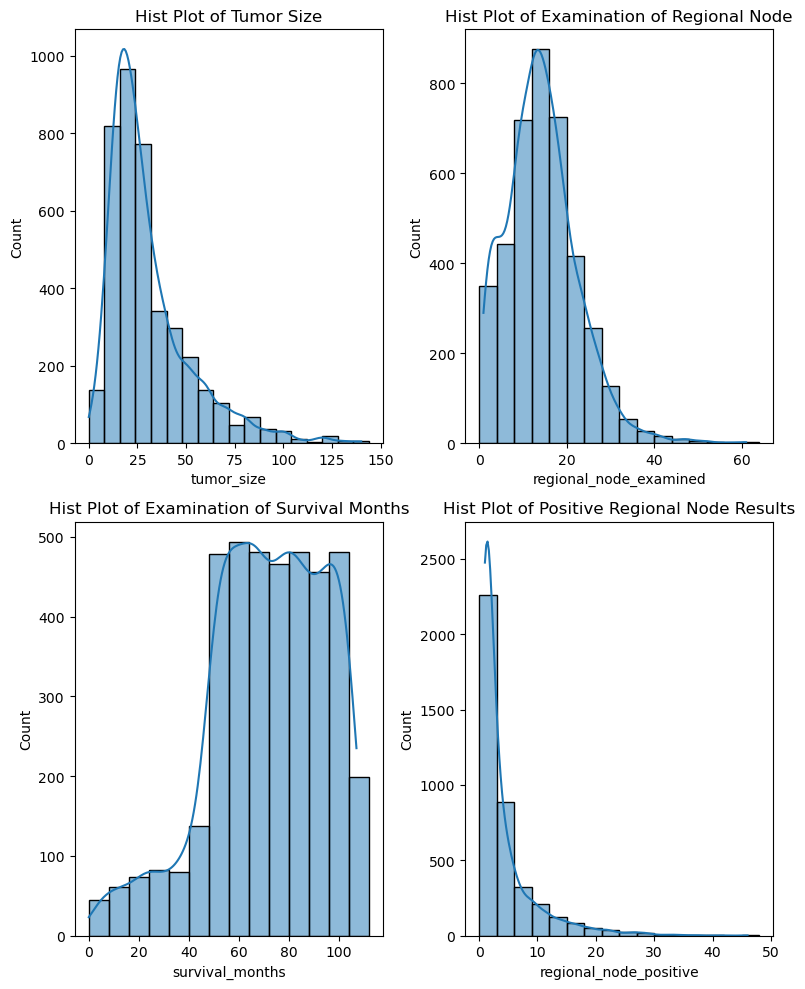

In [13]:
plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
sb.histplot(numerical_columns.tumor_size, kde= True, bins = calculate_bin_edges(numerical_columns.tumor_size,8));
plt.title('Hist Plot of Tumor Size');

plt.subplot(2,2,2)
sb.histplot(numerical_columns.regional_node_examined, kde = True,bins = calculate_bin_edges(numerical_columns.regional_node_examined,4))
plt.title('Hist Plot of Examination of Regional Node')

plt.subplot(2,2,3)
sb.histplot(numerical_columns.survival_months, kde = True, bins = calculate_bin_edges(numerical_columns.survival_months,8))
plt.title('Hist Plot of Examination of Survival Months')

plt.subplot(2,2,4)
sb.histplot(numerical_columns.regional_node_positive, kde = True, bins = calculate_bin_edges(numerical_columns.regional_node_positive,3))
plt.title('Hist Plot of Positive Regional Node Results')

plt.tight_layout();

<h3>Interpretation</h3>
<p>
    <ul>
        <li>The <i>tumor size</i>,<i> Examination of regional node</i>, and <i>Regional Node coming back positive</i> is skewed to the right, so mean is greater than the median. This means that outliers are present to the right side of their respective distributions</li>
        <li>The <i>Survival Months</i> distribution of patients is skewed to the left. The mean is less than median. The outliers are present on left side of the distribution.</li>
    </ul>
</p>

<b> Q2 - Univariate Plots</b>

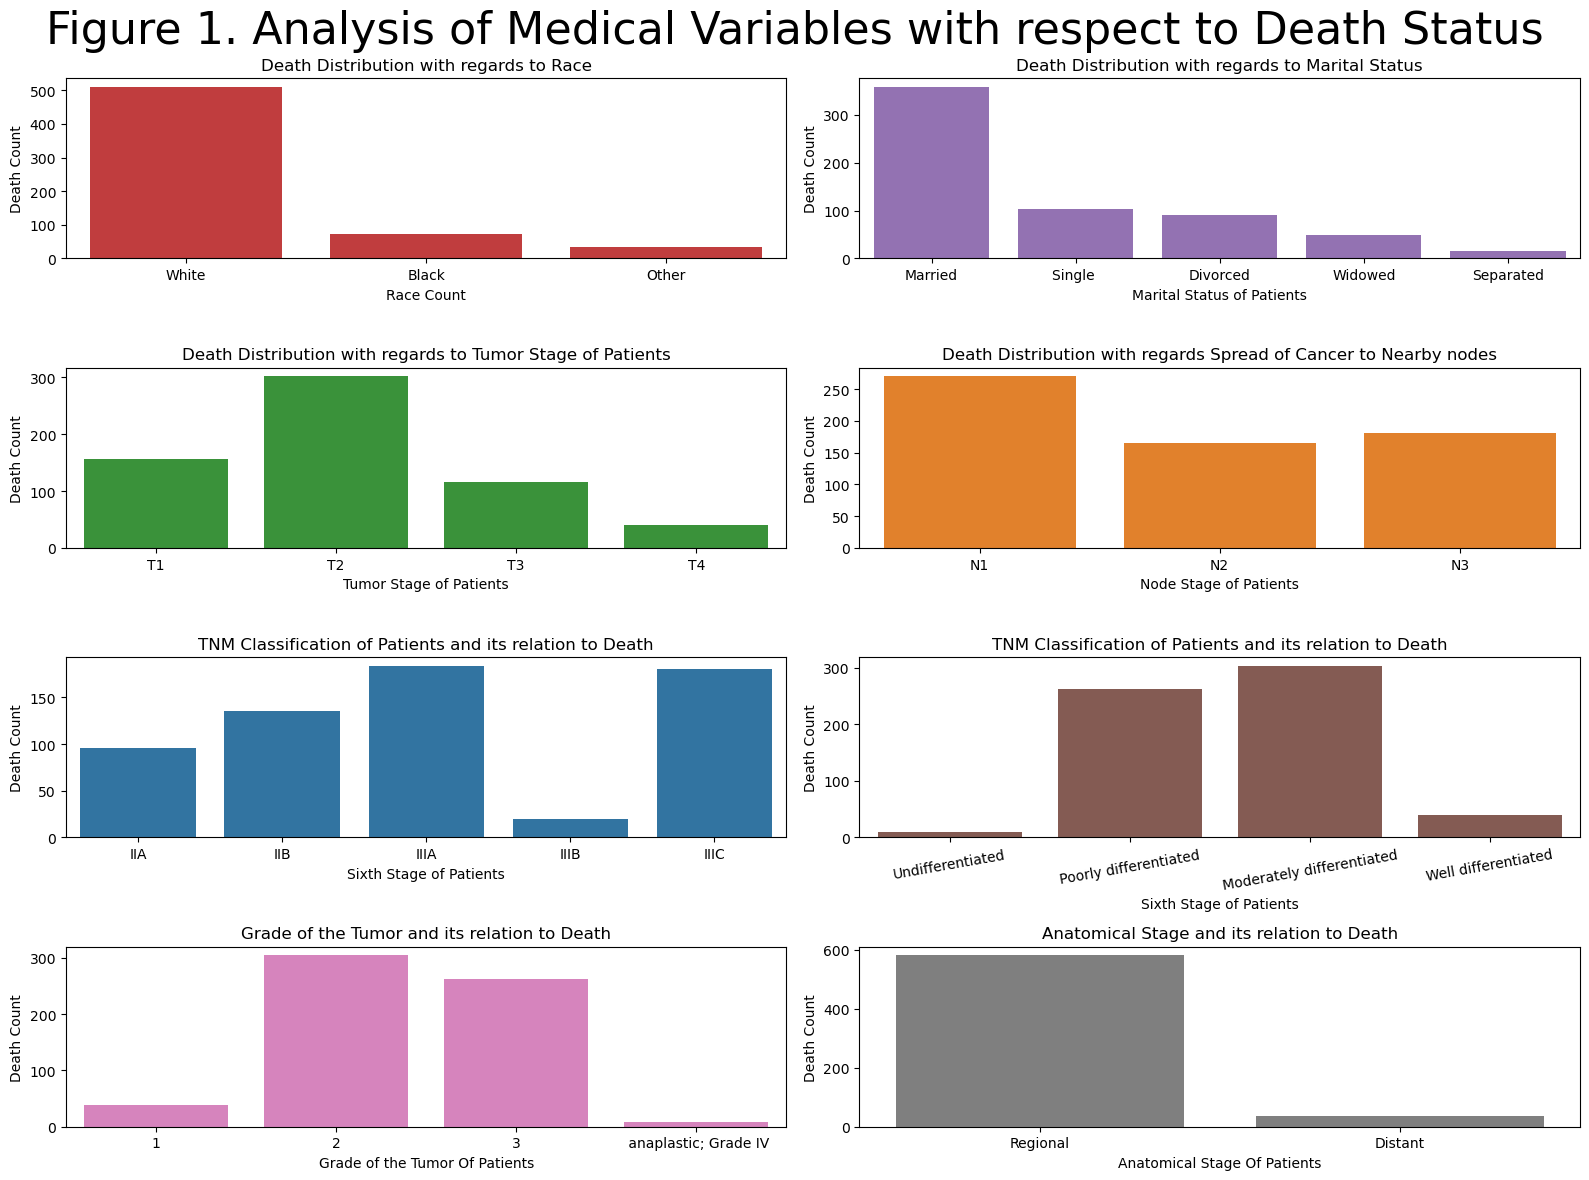

In [14]:
dead_patients = df_verOne[df_verOne['status'] == 'Dead']

fig, ax = plt.subplots(4,2, figsize = (16,12))
fig.suptitle("Figure 1. Analysis of Medical Variables with respect to Death Status", fontsize = 32)

color = sb.color_palette()[3]
order = dead_patients['race'].value_counts().index
sb.countplot(data = dead_patients, x = 'race', ax = ax[0,0], color = color, order= order)
ax[0,0].set_title("Death Distribution with regards to Race")
ax[0,0].set_ylabel("Death Count")
ax[0,0].set_xlabel("Race Count")

color = sb.color_palette()[4]
order = dead_patients['marital_status'].value_counts().index
sb.countplot(dead_patients,x = 'marital_status', order = order, color = color, ax = ax[0,1])
ax[0,1].set_title('Death Distribution with regards to Marital Status')
ax[0,1].set_ylabel("Death Count")
ax[0,1].set_xlabel("Marital Status of Patients")

color = sb.color_palette()[2]
# order = dead_patients['t_stage'].value_counts().index
sb.countplot(x = dead_patients['t_stage'], color = color, ax = ax[1,0], order = ['T1','T2','T3','T4']) #Ordinal Data -- Order Matters. Higher Numbers indicate greater extent of the disease
ax[1,0].set_title('Death Distribution with regards to Tumor Stage of Patients')
ax[1,0].set_ylabel("Death Count")
ax[1,0].set_xlabel("Tumor Stage of Patients")

color = sb.color_palette()[1]
order = dead_patients['n_stage'].value_counts().index
sb.countplot(x = dead_patients['n_stage'], order = ['N1','N2','N3'], color = color, ax = ax[1,1])
ax[1,1].set_title('Death Distribution with regards Spread of Cancer to Nearby nodes')
ax[1,1].set_ylabel("Death Count")
ax[1,1].set_xlabel("Node Stage of Patients")

color = sb.color_palette()[0]
order = dead_patients['sixth_stage'].value_counts().index
sb.countplot(x = dead_patients['sixth_stage'], color = color, ax = ax[2,0], order = ['IIA','IIB','IIIA','IIIB','IIIC'])
ax[2,0].set_title('TNM Classification of Patients and its relation to Death')
ax[2,0].set_ylabel("Death Count")
ax[2,0].set_xlabel("Sixth Stage of Patients")

color = sb.color_palette()[5]
order = dead_patients['differentiate'].value_counts().index
sb.countplot(x = dead_patients['differentiate'], color = color, ax = ax[2,1], order = ['Undifferentiated', 'Poorly differentiated','Moderately differentiated','Well differentiated'])
ax[2,1].set_title('TNM Classification of Patients and its relation to Death')
ax[2,1].set_ylabel("Death Count")
ax[2,1].set_xlabel("Sixth Stage of Patients")
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(10) # (GfG, 2022)

color = sb.color_palette()[6]
sb.countplot(x = dead_patients['grade'], color = color, ax = ax[3,0], order = ['1','2','3',' anaplastic; Grade IV'])
ax[3,0].set_title('Grade of the Tumor and its relation to Death')
ax[3,0].set_ylabel("Death Count")
ax[3,0].set_xlabel("Grade of the Tumor Of Patients")

color = sb.color_palette()[7]
sb.countplot(x = dead_patients['a_stage'], color = color, ax = ax[3,1])
ax[3,1].set_title('Anatomical Stage and its relation to Death')
ax[3,1].set_ylabel("Death Count")
ax[3,1].set_xlabel("Anatomical Stage Of Patients")



plt.tight_layout()

<h3> Interpretation</h3>
<p>
    <ul>
        <li><b>Classes of People Who are more Likely to die from cancer are:</b>
            <ul>
                <li>White</li>
                <li>Married</li>
            </ul>
        </li>
        <li>People who have Tumor Stage of T2 died more frequently than all other stages, with higher stage implying greater extent of the disease. The same is true for peeple who have N1 stage lymph involvement. The above results are combined in one criterion called sixth stage, in which patients who were diagnosed with IIIA disease died more frequently</li>
        <li>Surprisingly, people who's cancer was moderately differentiated, suggesting that it was a slow growing and less aggressive cancer, died more frequently than other types.</li>
        <li>
            Finally, patients with grade 2 and 3 cancer suffered the most deaths, as well as those patients who cancer had spread beyond the original site 
        </li>
    </ul>
</p>

<b>Q3 - Multivariate Plots</b>

<b> a </b>

In [15]:
numerical_columns.corr()

,age,tumor_size,regional_node_examined,regional_node_positive,survival_months
age,1.000000,-0.077240,-0.033186,0.012743,-0.010449
tumor_size,-0.077240,1.000000,0.105703,0.242640,-0.089535
regional_node_examined,-0.033186,0.105703,1.000000,0.411520,-0.023050
regional_node_positive,0.012743,0.242640,0.411520,1.000000,-0.133725
survival_months,-0.010449,-0.089535,-0.023050,-0.133725,1.000000


<Axes: title={'center': 'Analyzing Correlation amongst Numerical Columns'}>

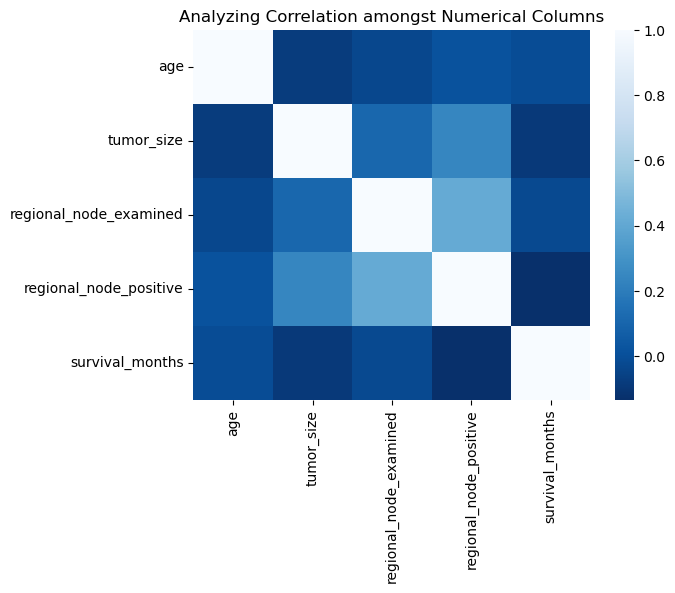

In [16]:
plt.title('Analyzing Correlation amongst Numerical Columns');
sb.heatmap(data = numerical_columns.corr(), cmap = 'Blues_r')

<b> Important Findings </b>
<ul>
    <li>There is a negative correlation between Survival Month and Tumor Size. This means that the greater tumour size you have, the less number of months you will survive</li>
    <li>
        There is a slight negative correlation between survival months and your regional node test coming back positive
    </li>
    <li>
        There is a slight positive link b/w you examining your regional node and it coming back positive. Likewise with your regional node coming back positive and tumor size.
    </li>
</ul>

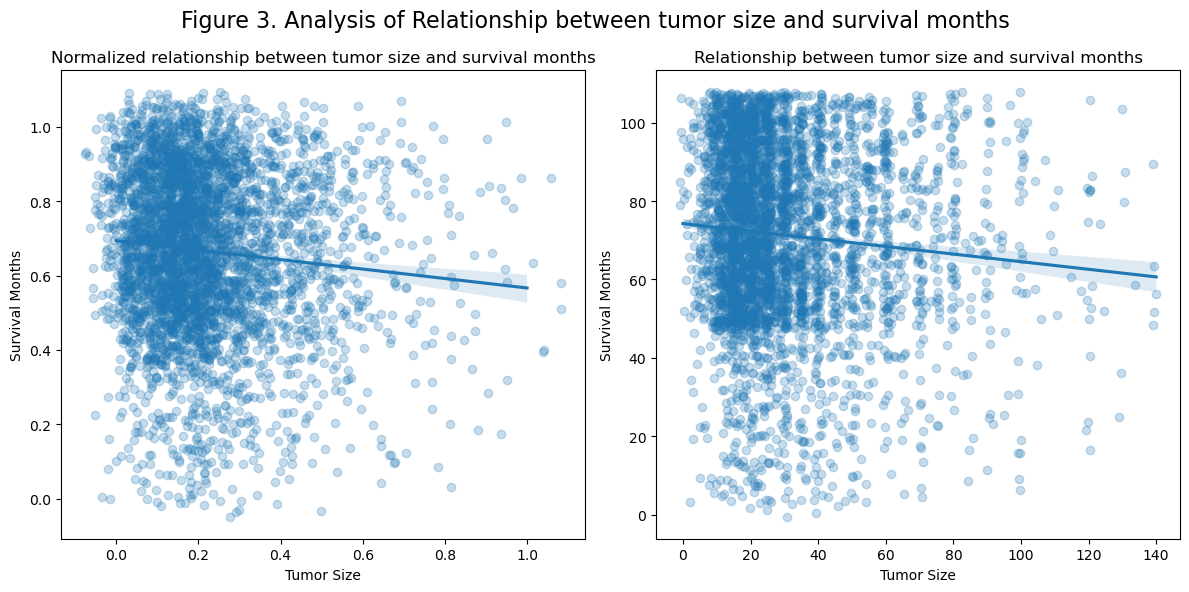

In [17]:
norm_tumour_size = normalize(numerical_columns['tumor_size'])
norm_survival_months = normalize(numerical_columns['survival_months'])

fig, ax = plt.subplots(1,2, figsize = (12,6))
fig.suptitle('Figure 3. Analysis of Relationship between tumor size and survival months', fontsize = 16)

sb.regplot(data = numerical_columns,x = norm_tumour_size, y = norm_survival_months, x_jitter= 0.1, y_jitter=0.1, scatter_kws= {'alpha': 1/4}, ax=ax[0])
ax[0].set_title('Normalized relationship between tumor size and survival months')
ax[0].set_ylabel('Survival Months')
ax[0].set_xlabel('Tumor Size')

sb.regplot(x = numerical_columns['tumor_size'], y = numerical_columns['survival_months'], x_jitter= 1, y_jitter=1, scatter_kws= {'alpha': 1/4}, ax = ax[1])
ax[1].set_title('Relationship between tumor size and survival months')
ax[1].set_ylabel('Survival Months')
ax[1].set_xlabel('Tumor Size')

plt.tight_layout()

<b>b</b>

<b> Analyzing distributions with respect to marital status </b>

Text(0.5, 1.0, 'Survival Months of Patients with regards to marital status')

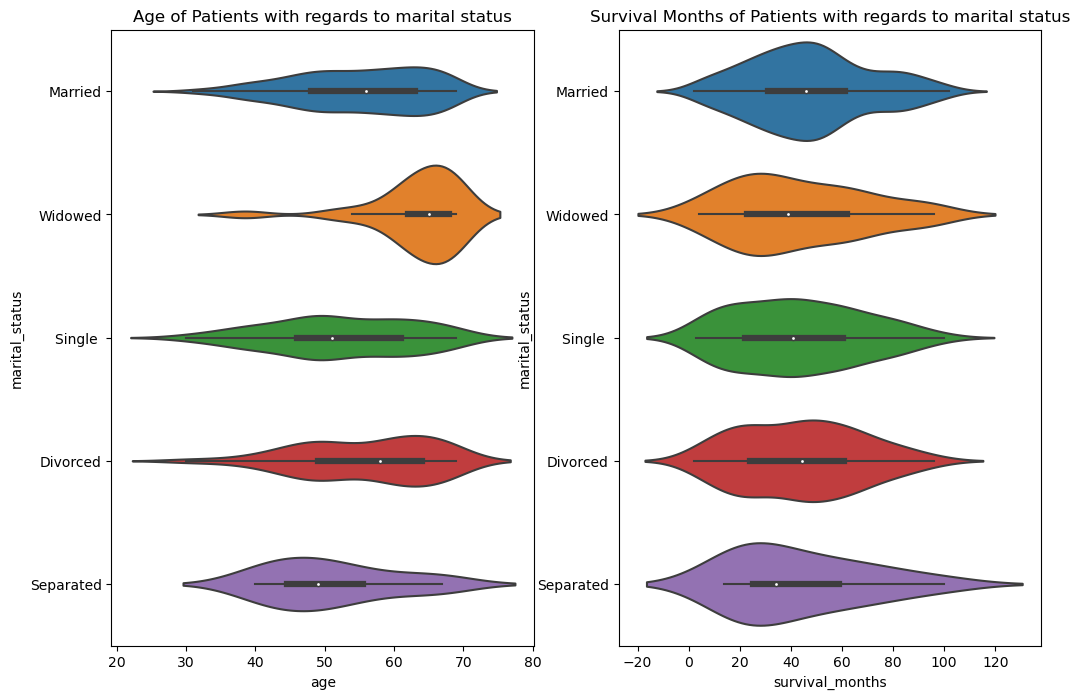

In [18]:
fig, ax = plt.subplots(1,2, figsize = (12,8))

sb.violinplot(y = dead_patients['marital_status'], x = dead_patients['age'], ax = ax[0])
ax[0].set_title('Age of Patients with regards to marital status')
sb.violinplot(y = dead_patients['marital_status'], x = dead_patients['survival_months'], ax = ax[1])
ax[1].set_title('Survival Months of Patients with regards to marital status')


There seems to be no apparent link amongst how medical variable would cause more death amongst married people than non-married people.

In [19]:
df_verOne.groupby('marital_status')['status'].value_counts()

marital_status  status
Divorced        Alive      396
                Dead        90
Married         Alive     2284
                Dead       358
Separated       Alive       30
                Dead        15
Single          Alive      511
                Dead       104
Widowed         Alive      186
                Dead        49
Name: count, dtype: int64

<b> Q4 - Identifying and Removing Outliers </b>

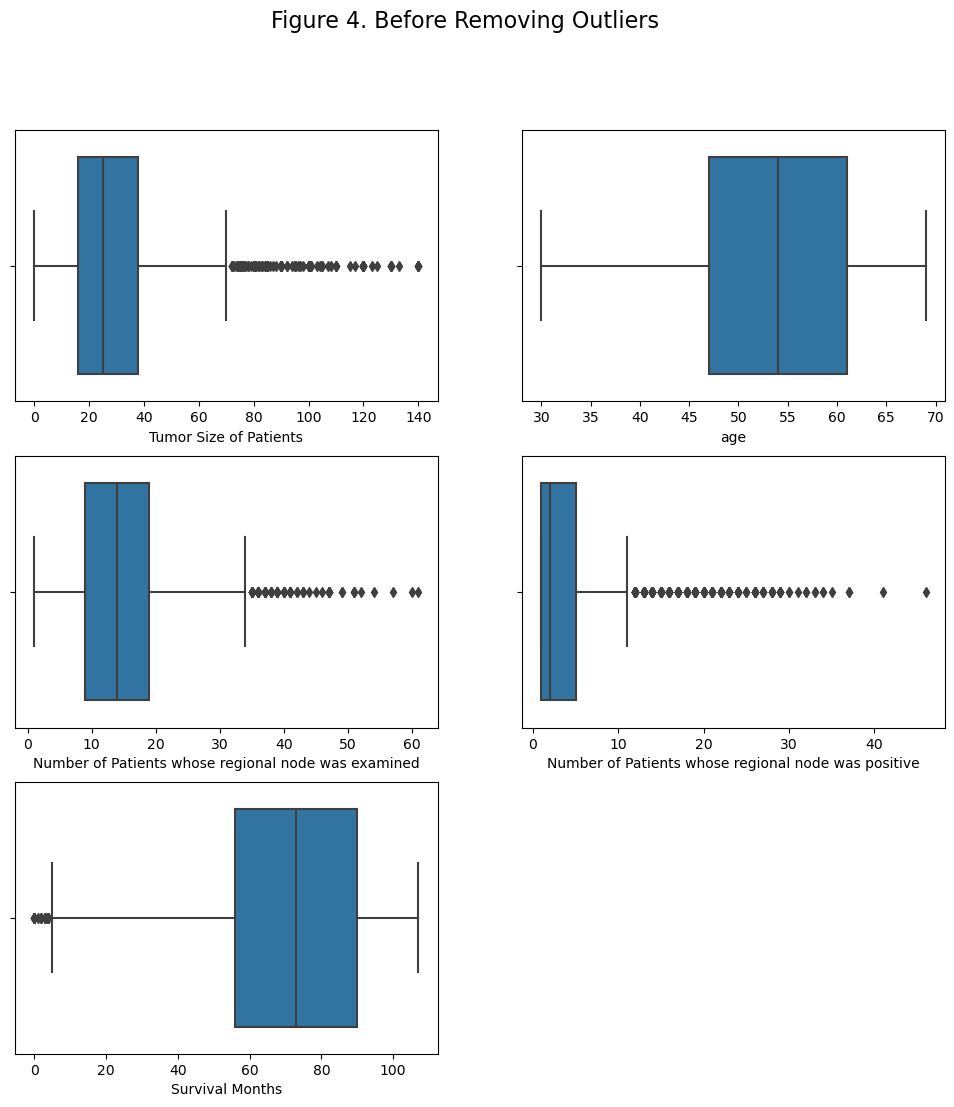

In [20]:
df_verTwo = df_verOne.copy()

fig, ax = plt.subplots(3,2, figsize = (12,12))
fig.suptitle('Figure 4. Before Removing Outliers', fontsize=16)

sb.boxplot(data = df_verTwo, x = df_verTwo['tumor_size'], ax=ax[0, 0])
ax[0,0].set_xlabel('Tumor Size of Patients')

sb.boxplot(data = df_verTwo, x = df_verTwo['age'], ax = ax[0,1])
sb.boxplot(data = df_verTwo, x = df_verTwo['regional_node_examined'], ax = ax[1,0])
ax[1,0].set_xlabel('Number of Patients whose regional node was examined')
sb.boxplot(data = df_verTwo, x = df_verTwo['regional_node_positive'], ax = ax[1,1])
ax[1,1].set_xlabel('Number of Patients whose regional node was positive')
sb.boxplot(data = df_verTwo, x = df_verTwo['survival_months'], ax = ax[2,0])
ax[2,0].set_xlabel('Survival Months')

ax[2,1].axis('off');

In [21]:
from scipy.stats.mstats import winsorize
# df_verTwo['tumor_size'] = winsorize(df_verTwo['tumor_size'], limits=[0.08,0.08]) #8% top and 8% bottom replaced by 92th and 8th percentile respectively
df_verTwo['regional_node_examined'] = winsorize(df_verTwo['regional_node_examined'], limits = [0,0.1])
df_verTwo['regional_node_positive'] = winsorize(df_verTwo['regional_node_positive'], limits = [0,0.1])
df_verTwo['survival_months'] = winsorize(df_verTwo['survival_months'], limits = [0.05,0])

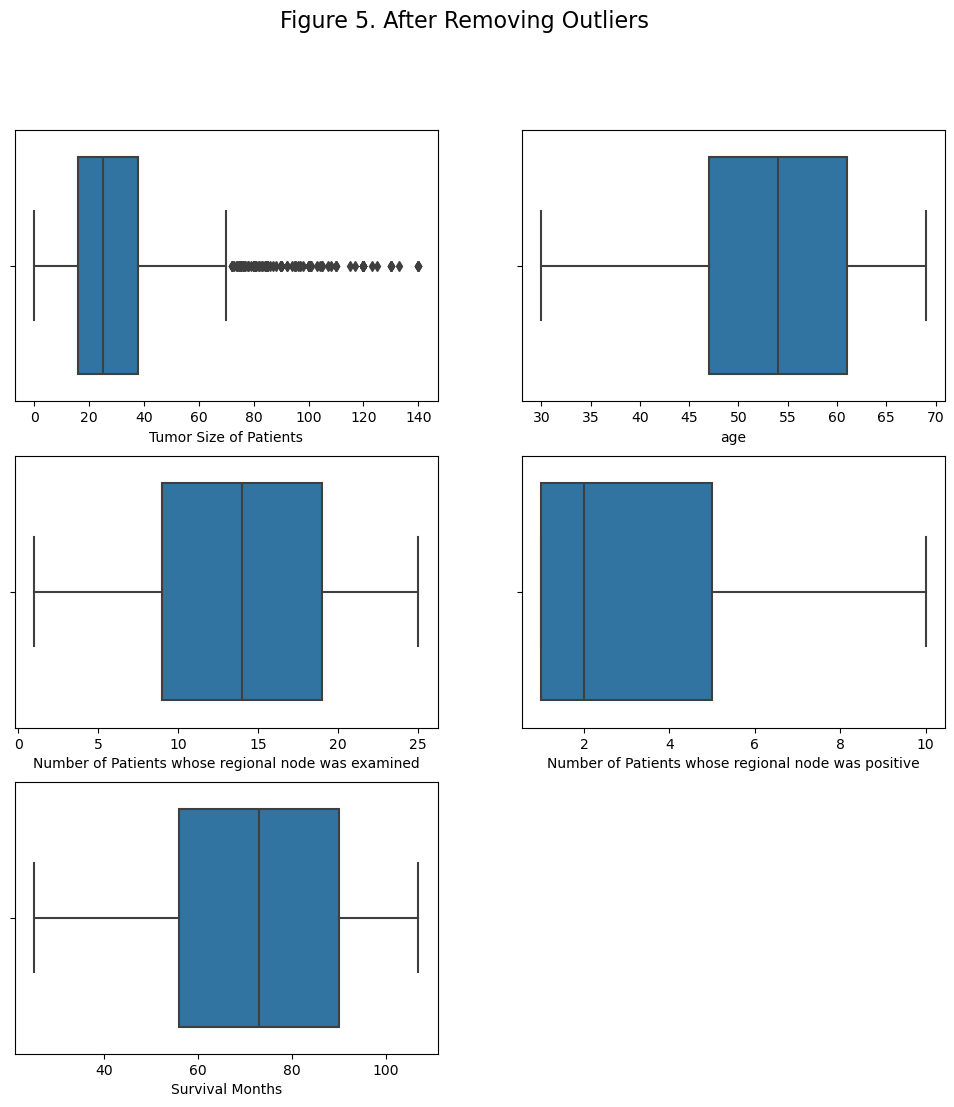

In [22]:
fig, ax = plt.subplots(3,2, figsize = (12,12))
fig.suptitle('Figure 5. After Removing Outliers', fontsize=16)

sb.boxplot(data = df_verTwo, x = df_verTwo['tumor_size'], ax=ax[0, 0])
ax[0,0].set_xlabel('Tumor Size of Patients')

sb.boxplot(data = df_verTwo, x = df_verTwo['age'], ax = ax[0,1])
sb.boxplot(data = df_verTwo, x = df_verTwo['regional_node_examined'], ax = ax[1,0])
ax[1,0].set_xlabel('Number of Patients whose regional node was examined')
sb.boxplot(data = df_verTwo, x = df_verTwo['regional_node_positive'], ax = ax[1,1])
ax[1,1].set_xlabel('Number of Patients whose regional node was positive')
sb.boxplot(data = df_verTwo, x = df_verTwo['survival_months'], ax = ax[2,0])
ax[2,0].set_xlabel('Survival Months')

ax[2,1].axis('off');

<h3>Explanation</h3>
<p>
    <ul>
        <li>
            For Examining Outliers, we used the boxplots. The shape of the boxplot shows how the data is distributed and it also shows any outliers. (Numeracy, Maths and Statistics - Academic Skills Kit, n.d.)
        </li>
        <li>
            <b>Rationale for not Winsorizing Tumor Size: </b>
            Tumor Size contains lots of zero values. We will be examining that further down the road
        </li>
        <li>
            With Regards to others:
            <ul>
                <li><b>Regional Node Examination and Regional node Positive: </b>According to Figure 4, These distribution contained alot of outliers on the right side, hence we replaced 10% of all the outliers on the right side with the 90th Percentile Value</li>
                <li><b>Survival Months: </b>According to Figure 4, This distribution contained alot of outliers on the left side, hence we replaced 5% of all the outliers on the right side with the 95th Percentile Value</li>
                <!-- <li><b></b></li> -->
            </ul>
        </li>
    </ul>
</p>

<b>Q5 - Treating Missing Values</b>

In [23]:
(df_verTwo.isna().sum())

age                       0
race                      0
marital_status            0
t_stage                   5
n_stage                   0
sixth_stage               0
differentiate             6
grade                     0
a_stage                   0
tumor_size                6
estrogen_status           0
progesterone_status       0
regional_node_examined    0
regional_node_positive    0
survival_months           7
status                    0
dtype: int64

In [24]:
df_verTwo['t_stage'] = df_verTwo['t_stage'].fillna(df_verTwo['t_stage'].mode().iat[0])
df_verTwo['differentiate'] = df_verTwo['differentiate'].fillna(df_verTwo['differentiate'].mode().iat[0])
df_verTwo['survival_months'] = df_verTwo['survival_months'].fillna(df_verTwo['survival_months'].mean())
df_verTwo.isna().sum().sum()

6

<h3>Explanation</h3>
<p>
    <ul>
        <li>Categorial Variables t_stage was replaced with the mode</li>
        <li>Numerical Variable such as tumor_size and survival_months was replaced with the mean. The reason for choosing mean was because we had removed outliers in the previous step.</li>
        <!-- <li></li> -->
    </ul>
</p>

<b>Q6 - Impute Zeroes</b>

In [25]:
# '0' in df_verTwo['progesterone_status'][df_verTwo['progesterone_status'] == '0'].values.astype('int')

In [26]:
columns = df_verTwo.columns.tolist()
toImpute = []
for column in columns:
    if '0' in (df_verTwo[column][(df_verTwo[column] == '0') | (df_verTwo[column] == 0)].values).astype('str'):
        toImpute.append(column)
print(df_verTwo[toImpute].value_counts())
df_verTwo[toImpute] = df_verTwo[toImpute].replace('0','Negative')
print('After Imputing:','0' in df_verTwo[toImpute][df_verTwo[toImpute] == '0'].values.astype('str'))

progesterone_status
Positive               3321
Negative                697
0                         5
Name: count, dtype: int64
After Imputing: False


<div>
    <b> Explanation </b>
    <ul>
        <li>
                <p> progesterone_status column has three types of values. Since the negative value already exists, we don't have a need for the '0' value as they both represent the same thing. Hence, we will be imputing that with negative </p>
        </li>

</div>


In [27]:
df_verOne[['t_stage', 'tumor_size']]

,t_stage,tumor_size
0,T1,4.0
1,T2,35.0
2,T3,63.0
3,T1,18.0
4,T2,41.0
...,...,...
4019,T1,9.0
4020,T2,46.0
4021,T2,22.0
4022,T2,44.0


In [28]:
df_verTwo[['t_stage', 'tumor_size']][df_verTwo['tumor_size'] == 0].size

12

<p>Tumor from stage 1 onwards don't have a tumor size of zero. Hence we will be imputing these values</p>(Breast Cancer Tumor Size Chart & Measurement Explained, n.d.)

In [29]:
df_verTwo['tumor_size'] = winsorize(df_verTwo['tumor_size'], limits = [0.08,0.08])
df_verTwo[['t_stage', 'tumor_size']][df_verTwo['tumor_size'] == 0].size

0

In [30]:
df_verTwo['progesterone_status'].unique()

array(['Positive', 'Negative'], dtype=object)

<b> Q7 - Rescale </b>

In [31]:
df_verThree = df_verTwo.copy()

print(df_verThree['grade'].unique())
df_verThree['grade'] = df_verThree['grade'].replace(' anaplastic; Grade IV', '4')
print('After Replacing:',df_verThree['grade'].unique())


type_of_object_columns = df_verThree.select_dtypes(include = ['object'])
df_verThree[type_of_object_columns.columns.tolist()]=df_verThree[type_of_object_columns.columns.tolist()].astype('category')
# df_verThree['status'] = df_verThree['status'].str.replace('Alive', '1').str.replace('Dead', '0')
# df_verThree['status'] = df_verThree['status'].astype('int')
df_verThree['status'] = df_verThree['status'].cat.codes


df_verThree['estrogen_status'] = df_verThree['estrogen_status'].cat.codes
df_verThree['progesterone_status'] = df_verThree['progesterone_status'].cat.codes

df_verThree['a_stage'] = df_verThree['a_stage'].cat.codes

df_verThree['tumor_size'] = round(normalize(df_verThree['tumor_size']),2)
df_verThree['survival_months'] = round(normalize(df_verThree['survival_months']),2)

df_verFour = df_verThree.copy()
df_verFour = pd.get_dummies(df_verThree, prefix = ['differentiate', 'marital_status', 't_stage','sixth_stage'], columns = ['differentiate', 'marital_status', 't_stage','sixth_stage'])



['3' '2' '1' ' anaplastic; Grade IV']
After Replacing: ['3' '2' '1' '4']


In [32]:
df_verFour.sample(5)

,age,race,n_stage,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,...,marital_status_Widowed,t_stage_T1,t_stage_T2,t_stage_T3,t_stage_T4,sixth_stage_IIA,sixth_stage_IIB,sixth_stage_IIIA,sixth_stage_IIIB,sixth_stage_IIIC
1312,60,Other,N1,2,1,0.06,1,1,1,1,...,False,True,False,False,False,True,False,False,False,False
101,47,White,N1,3,1,0.09,1,1,25,1,...,False,True,False,False,False,True,False,False,False,False
1573,64,White,N1,2,1,0.11,1,1,9,1,...,False,True,False,False,False,True,False,False,False,False
2146,42,White,N1,2,1,0.26,1,1,8,1,...,False,False,True,False,False,False,True,False,False,False
1052,54,White,N2,2,1,0.15,1,1,17,7,...,False,True,False,False,False,False,False,True,False,False


In [33]:
df_verFour.columns = df_verFour.columns.str.replace(' ','_').str.lower()

In [34]:
columns = df_verFour.columns.tolist()
r_one = re.compile('differentiate*')
differentiate_columns = list(filter(r_one.match, columns)) #(Regular Expressions: Search in List, n.d.)
print(differentiate_columns)

r_two = re.compile('marital_status*')
relationship_status_columns = list(filter(r_two.match, columns))
print(relationship_status_columns)

r_three = re.compile('t_stage*')
t_stage_columns = list(filter(r_three.match,columns))
print(t_stage_columns)

# r_four = re.compile('n_stage*')
# n_stage_columns = list(filter(r_four.match, columns))
# print(n_stage_columns)

r_five = re.compile('sixth_stage*')
sixth_stage_columns = list(filter(r_five.match, columns))
print(sixth_stage_columns)


['differentiate_moderately_differentiated', 'differentiate_poorly_differentiated', 'differentiate_undifferentiated', 'differentiate_well_differentiated']
['marital_status_divorced', 'marital_status_married', 'marital_status_separated', 'marital_status_single_', 'marital_status_widowed']
['t_stage_t1', 't_stage_t2', 't_stage_t3', 't_stage_t4']
['sixth_stage_iia', 'sixth_stage_iib', 'sixth_stage_iiia', 'sixth_stage_iiib', 'sixth_stage_iiic']


In [35]:
df_verThree['a_stage'].unique()

array([1, 0], dtype=int8)

In [36]:
relevant_columns = differentiate_columns + ['grade', 'tumor_size', 'survival_months','status']
df_verFour.groupby('status')[['tumor_size','survival_months']].corr()

tumor_size  survival_months
status                                             
0      tumor_size         1.000000        -0.027701
       survival_months   -0.027701         1.000000
1      tumor_size         1.000000        -0.089172
       survival_months   -0.089172         1.000000

<Axes: xlabel='tumor_size', ylabel='survival_months'>

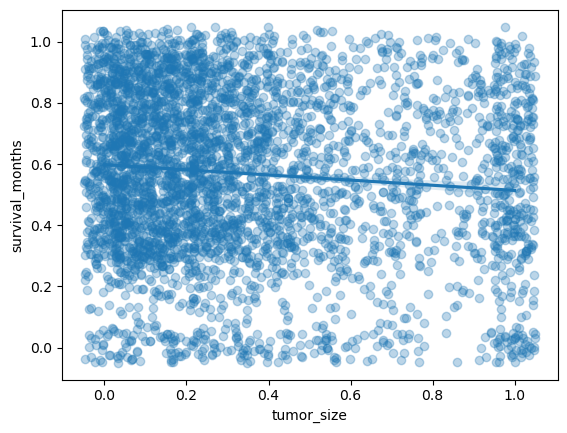

In [37]:
sb.regplot(x = df_verFour['tumor_size'], y = df_verFour['survival_months'], x_jitter=0.05, y_jitter=0.05, scatter_kws={'alpha': 0.3})

<ul>
<li><b>Label Encoding:</b> Changing Categorical Type into Numerical in order to feed to the model later down the road. In label encoding, we assign 0 and 1 without creating a new column. This works best when we have few categorical values...</li>
    <ul>
        <li>
            <b>Status:</b> Alive = 1, Dead = 0
        </li>
        <li>
            <b>Progesterone Status:</b> Positive = 1, Negative = 0
        </li>
        <li>
            <b>Estrogen Status:</b> Positive = 1, Negative = 0
        </li>
        <li>
            <b>a_stage:</b> Regional = 1, Distant = 0
        </li>
    </ul>
<li>
    <b>Normalizing:</b> Converting Values to a similar scale in order to improve the efficiency of the model
    <ul>
        <li>
            <b>Tumor Size</b>
        </li>
        <li>
            <b>Survival Months</b     
        </li>
    </ul>
</li>
    <li>
        <b>One Hot Encoding: </b> Changing Categorical type to numerical in order to feed to the model further down the road. One hot encoding works best when we have categorical data with many distinct categorical values. In this scenario, label encoding is not the best option as it may cause bias within the model
    </li>
    <ul>
    <li><b>differentiate</b></li>
    <li><b>marital_status</b></li>
    <li><b>t_stage</b></li>
    <li><b>sixth_stage</b></li>
    </ul>
</ul>

<b>Q8 - Feature Engineering and Feature Removal</b>

In [38]:
df_verFive = df_verFour.copy()
# df_verFive['survival_chance'] = (df_verFive['tumor_size'] * df_verFive['survival_months']) * 100

# feature_removal = ['estrogen_status', 'progesterone_status', 'n_stage', 'race']
# df_verFive.drop(columns = feature_removal, inplace = True, axis = 1)

# df_verFive['status']

------------------------------

<h1>Machine Learning</h1>
<p><b> Classification Problem:</b> Determine if the patient Survived or Not</p>

Splitting Calling Fitting Predicting

<b>Q1 </b>

<b> Test One </b>

In [39]:
test_number_one = differentiate_columns + relationship_status_columns + ['age']

feature_set_one = test_number_one
target_set_one = ['status']
feature_one = df_verFive.loc[:,feature_set_one]
target_one = df_verFive.loc[:,target_set_one]

Xtrain_one, Xtest_one, ytrain_one, ytest_one = train_test_split(
    feature_one,
    target_one,
    test_size=0.3,
    random_state=42
)

model_one = RandomForestClassifier()
model_one.fit(Xtrain_one, ytrain_one)
ypredict_one = model_one.predict(Xtest_one)

accuracy_one = accuracy_score(ytest_one, ypredict_one)
matrix_one = confusion_matrix(ytest_one, ypredict_one)
precision_one = precision_score(ytest_one, ypredict_one, average='weighted', labels = np.unique(ypredict_one))
recall_one = recall_score(ytest_one, ypredict_one, average='weighted', labels = np.unique(ypredict_one))
f1_one = f1_score(ytest_one, ypredict_one, average='weighted', labels = np.unique(ypredict_one))

score_summary = {'Accuracy':round(accuracy_one,2), 'Precision':round(precision_one,2), 'Recall': round(recall_one,2), 'F1': round(f1_one,2)}

fpr_one, tpr_one, threshold_one = roc_curve(ytest_one, ypredict_one)
roc_auc_one = auc(fpr_one, tpr_one)


for key, value in score_summary.items():
    print(f'{key} Score is: {value}')
print(matrix_one)


Accuracy Score is: 0.83
Precision Score is: 0.75
Recall Score is: 0.83
F1 Score is: 0.77
[[988  30]
 [180   9]]


/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<b> Test Two </b>

In [40]:
test_number_two = relationship_status_columns 

feature_set_two = test_number_two
target_set_two = ['status']
feature_two = df_verFive.loc[:,feature_set_two]
target_two = df_verFive.loc[:,target_set_two]

Xtrain_two, Xtest_two, ytrain_two, ytest_two = train_test_split(
    feature_two,
    target_two,
    test_size=0.3,
    random_state=42
)

model_two = LogisticRegression()
model_two.fit(Xtrain_two, ytrain_two)
ypredict_two = model_two.predict(Xtest_two)

accuracy_two = accuracy_score(ytest_two, ypredict_two)
matrix_two = confusion_matrix(ytest_two, ypredict_two)
precision_two = precision_score(ytest_two, ypredict_two, average='weighted', labels = np.unique(ypredict_two))
recall_two = recall_score(ytest_two, ypredict_two, average='weighted', labels = np.unique(ypredict_two))
f1_two = f1_score(ytest_two, ypredict_two, average='weighted', labels = np.unique(ypredict_two))


fpr_two, tpr_two, threshold_two = roc_curve(ytest_two, ypredict_two)
roc_auc_two = auc(fpr_two, tpr_two)

score_summary = {'Accuracy':round(accuracy_two,2), 'Precision':round(precision_two,2), 'Recall': round(recall_two,2), 'F1': round(f1_two,2)}

for key, value in score_summary.items():
    print(f'{key} Score is: {value}')
print(matrix_two)


/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score is: 0.84
Precision Score is: 0.84
Recall Score is: 1.0
F1 Score is: 0.92
[[1018    0]
 [ 189    0]]


<b> Test 3 </B>

In [41]:
test_number_three = differentiate_columns + sixth_stage_columns + t_stage_columns + ['age']

feature_set_three = test_number_three
target_set_three = ['status']
feature_three = df_verFive.loc[:,feature_set_three]
target_three = df_verFive.loc[:,target_set_three]

Xtrain_three, Xtest_three, ytrain_three, ytest_three = train_test_split(
    feature_three,
    target_three,
    test_size=0.3,
    random_state=42
)

model_three = GaussianNB()
model_three.fit(Xtrain_three, ytrain_three)
ypredict_three = model_three.predict(Xtest_three)

accuracy_three = accuracy_score(ytest_three, ypredict_three)
matrix_three = confusion_matrix(ytest_three, ypredict_three)
precision_three = precision_score(ytest_three, ypredict_three, average='weighted', labels = np.unique(ypredict_three))
recall_three = recall_score(ytest_three, ypredict_three, average='weighted', labels = np.unique(ypredict_three))
f1_three = f1_score(ytest_three, ypredict_three, average='weighted', labels = np.unique(ypredict_three))

fpr_three, tpr_three, threshold_three = roc_curve(ytest_three, ypredict_three)
roc_auc_three = auc(fpr_three, tpr_three)

score_summary = {'Accuracy':round(accuracy_three,2), 'Precision':round(precision_three,2), 'Recall': round(recall_three,2), 'F1': round(f1_three,2)}

for key, value in score_summary.items():
    print(f'{key} Score is: {value}')
print(matrix_three)



Accuracy Score is: 0.82
Precision Score is: 0.81
Recall Score is: 0.82
F1 Score is: 0.81
[[920  98]
 [122  67]]


/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<b> Test 4 </B>

In [42]:
test_number_four = sixth_stage_columns + t_stage_columns + differentiate_columns

feature_set_four = test_number_four
target_set_four = ['status']
feature_four = df_verFive.loc[:,feature_set_four]
target_four = df_verFive.loc[:,target_set_four]

Xtrain_four, Xtest_four, ytrain_four, ytest_four = train_test_split(
    feature_four,
    target_four,
    test_size=0.3,
    random_state=42
)

model_four = SVC(kernel='linear')
model_four.fit(Xtrain_four, ytrain_four)
ypredict_four = model_four.predict(Xtest_four)

accuracy_four = accuracy_score(ytest_four, ypredict_four)
matrix_four = confusion_matrix(ytest_four, ypredict_four)
precision_four = precision_score(ytest_four, ypredict_four, average='weighted', labels = np.unique(ypredict_four))
recall_four = recall_score(ytest_four, ypredict_four, average='weighted', labels = np.unique(ypredict_four))
f1_four = f1_score(ytest_four, ypredict_four, average='weighted', labels = np.unique(ypredict_four))


fpr_four, tpr_four, threshold_four = roc_curve(ytest_four, ypredict_four)
roc_auc_four = auc(fpr_four, tpr_four)


score_summary = {'Accuracy':round(accuracy_three,2), 'Precision':round(precision_three,2), 'Recall': round(recall_three,2), 'F1': round(f1_three,2)}

for key, value in score_summary.items():
    print(f'{key} Score is: {value}')
print(matrix_four)


/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score is: 0.82
Precision Score is: 0.81
Recall Score is: 0.82
F1 Score is: 0.81
[[1018    0]
 [ 189    0]]


------------

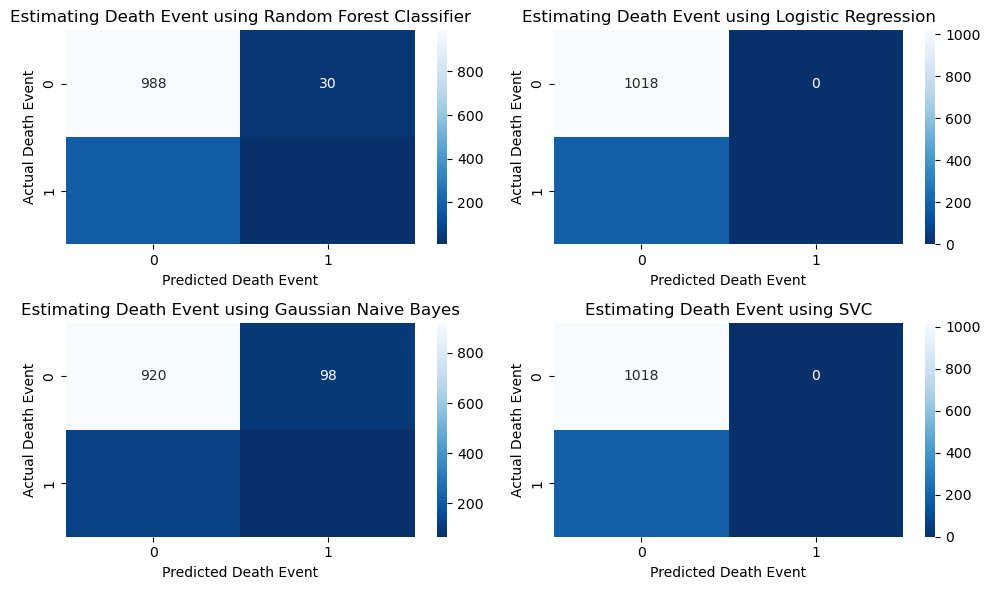

In [43]:
fig, ax = plt.subplots(2,2, figsize = (10,6))

sb.heatmap(matrix_one, cmap = 'Blues_r', annot=True, fmt ='d', ax= ax[0,0])
ax[0,0].set_xlabel('Predicted Death Event')
ax[0,0].set_ylabel('Actual Death Event')
ax[0,0].set_title('Estimating Death Event using Random Forest Classifier')

sb.heatmap(matrix_two, cmap = 'Blues_r', annot=True, fmt ='d', ax= ax[0,1])
ax[0,1].set_xlabel('Predicted Death Event')
ax[0,1].set_ylabel('Actual Death Event')
ax[0,1].set_title('Estimating Death Event using Logistic Regression')

sb.heatmap(matrix_three, cmap = 'Blues_r', annot=True, fmt ='d', ax= ax[1,0])
ax[1,0].set_xlabel('Predicted Death Event')
ax[1,0].set_ylabel('Actual Death Event')
ax[1,0].set_title('Estimating Death Event using Gaussian Naive Bayes')

sb.heatmap(matrix_four, cmap = 'Blues_r', annot=True, fmt ='d', ax= ax[1,1])
ax[1,1].set_xlabel('Predicted Death Event')
ax[1,1].set_ylabel('Actual Death Event')
ax[1,1].set_title('Estimating Death Event using SVC')

plt.tight_layout()

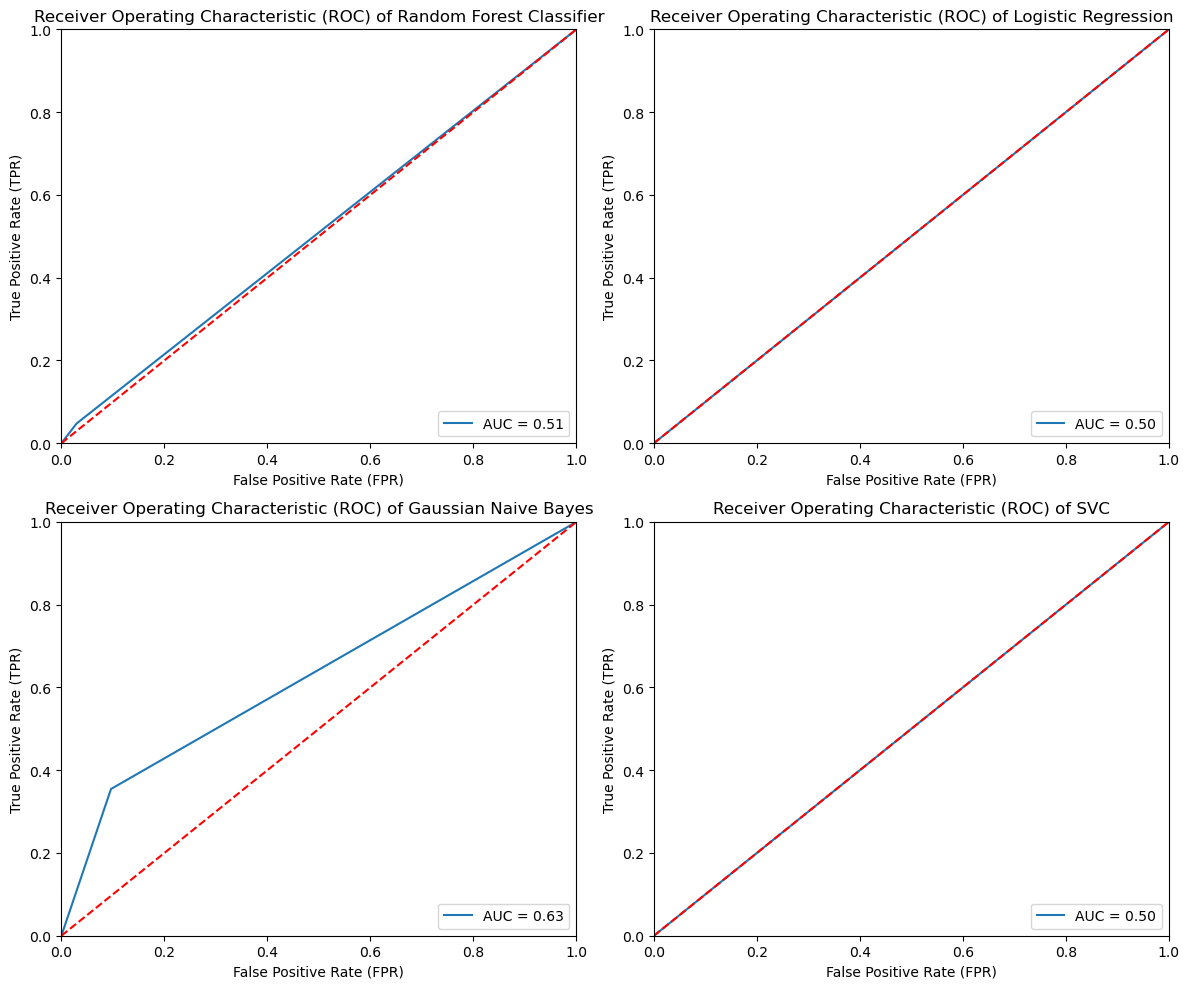

In [44]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(fpr_one, tpr_one, label = 'AUC = %0.2f' % roc_auc_one)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristic (ROC) of Random Forest Classifier')
plt.legend(loc = 'lower right')

plt.subplot(2,2,2)
plt.plot(fpr_two, tpr_two, label = 'AUC = %0.2f' % roc_auc_two)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristic (ROC) of Logistic Regression')
plt.legend(loc = 'lower right')

plt.subplot(2,2,3)
plt.plot(fpr_three, tpr_three, label = 'AUC = %0.2f' % roc_auc_three)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristic (ROC) of Gaussian Naive Bayes')
plt.legend(loc = 'lower right')

plt.subplot(2,2,4)
plt.plot(fpr_four, tpr_four, label = 'AUC = %0.2f' % roc_auc_four)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristic (ROC) of SVC')
plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()

<h2> Summary of Our Findings (Classification)</h2>
<div>
    <p>We ran Four tests, using different models and features each time around: </p>
    <p>For Test 1, we used Random Forest Classifier Model and all differentiate, relationship columns plus age. </p>
    <p>For Test 2, we used the Logistic Regression Model and Only the relationship column. This resulted in the model with the perfect recall score</p>
    <p>For Test 3, we used Gaussian Naive Bayes and included all the columns except The target.</p>
    <p> For Test 4, we included differentiate, tstage, and sixth stage columns plus the surival chance column the we feature engineered. The model used was SVC.</p>

    <p>The results of our comparision are summarized below: </p>
    
</div>

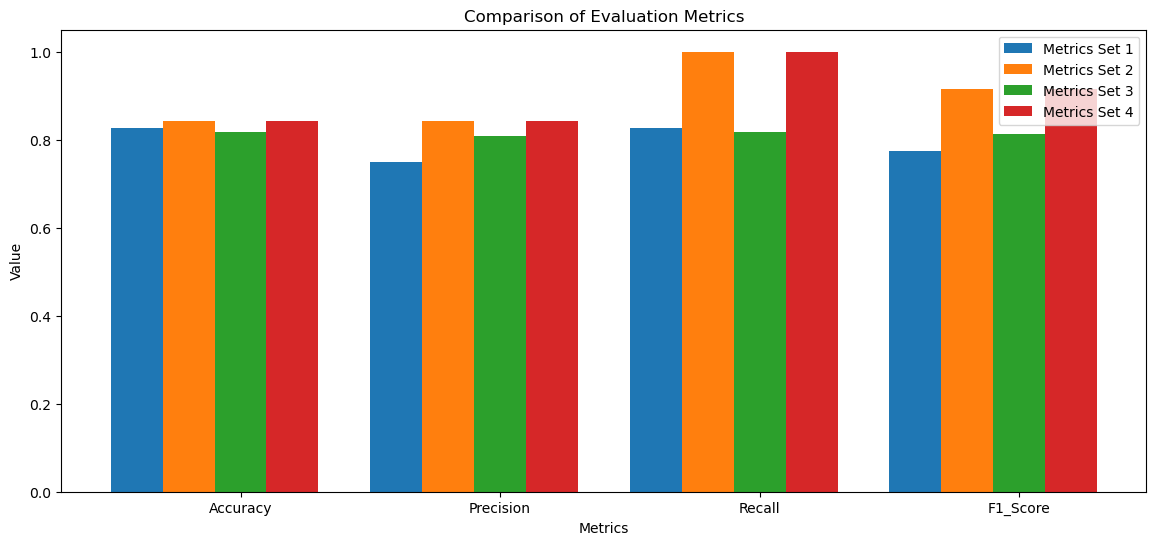

In [45]:
metrics = ['Accuracy','Precision','Recall','F1_Score']
values1 = [accuracy_one,precision_one,recall_one,f1_one]
values2 = [accuracy_two,precision_two,recall_two,f1_two]
values3 = [accuracy_three,precision_three,recall_three,f1_three]
values4 = [accuracy_four,precision_four,recall_four,f1_four]

# Plotting
plt.figure(figsize=(14, 6))

plt.bar(np.arange(len(metrics)) - 0.4, values1, width=0.2, label='Metrics Set 1')
plt.bar(np.arange(len(metrics)) - 0.2, values2, width=0.2, label='Metrics Set 2')
plt.bar(np.arange(len(metrics)) + 0, values3, width=0.2, label='Metrics Set 3')
plt.bar(np.arange(len(metrics)) + 0.2, values4, width=0.2, label='Metrics Set 4')

plt.xticks(np.arange(len(metrics)), metrics) 
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Comparison of Evaluation Metrics')

plt.legend()
plt.show()


<h3>Conclusion</h3>
<p>From the AUC curves and our comparison matrix, we can conclude that Gaussian Naive Bayes Model performed the best
</p>

<div>

</div>


<p><b>Regression Problem:</b> Number of survival months remaining for patients</p>

<b>Test One</b>

In [46]:
df_verSix = df_verFive.copy()
df_verSix['survival_months'] = denormalize(original=df_verOne['survival_months'], normalized= df_verFive['survival_months'])

In [47]:
reg_test_number_one = relationship_status_columns + ['age'] + t_stage_columns

reg_feature_set_one = reg_test_number_one
reg_target_set_one = ['survival_months']
reg_feature_one = df_verSix.loc[:,reg_feature_set_one]
reg_target_one = df_verSix.loc[:,reg_target_set_one]

reg_Xtrain_one, reg_Xtest_one, reg_ytrain_one, reg_ytest_one = train_test_split(
    reg_feature_one,
    reg_target_one,
    test_size=0.3,
    random_state=42
)

reg_model_one = GradientBoostingRegressor()
reg_model_one.fit(reg_Xtrain_one, reg_ytrain_one)
reg_ypredict_one = reg_model_one.predict(reg_Xtest_one)

r2_score_one = r2_score(reg_ytest_one, reg_ypredict_one)
mse_one = mean_squared_error(reg_ytest_one, reg_ypredict_one)
rmse_one = np.sqrt(mse_one)


score_summary = {'R2 Score':round(r2_score_one,2), 'Mean Squared Error:':round(mse_one,2), 'Root Mean Squared Error:': round(rmse_one,2)}

for key, value in score_summary.items():
    print(f'{key} Score is: {value}')


R2 Score Score is: -0.01
Mean Squared Error: Score is: 845.52
Root Mean Squared Error: Score is: 29.08


/home/ahmedhanifc/miniconda3/envs/learningDSAI/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<b> Test Two </b>

In [49]:
# reg_test_number_two = [column for column in df_verSix.columns if not column == 'survival_months']

# reg_feature_set_two = reg_test_number_two
# reg_target_set_two = [column for column in df_verSix.columns if column == 'survival_months']
# reg_feature_two = df_verSix.loc[:,reg_feature_set_two]
# reg_target_two = df_verSix.loc[:,reg_target_set_two]

# reg_Xtrain_two, reg_Xtest_two, reg_ytrain_two, reg_ytest_two = train_test_split(
#     reg_feature_two,
#     reg_target_two,
#     test_size=0.3,
#     random_state=42
# )

# reg_model_two = PoissonRegressor()
# reg_model_two.fit(reg_Xtrain_two, reg_ytrain_two)
# reg_ypredict_two = reg_model_two.predict(reg_Xtest_two)

# r2_score_two = r2_score(reg_ytest_two, reg_ypredict_two)
# mse_two = mean_squared_error(reg_ytest_two, reg_ypredict_two)
# rmse_two = np.sqrt(mse_two)


# score_summary = {'R2 Score':round(r2_score_two,2), 'Mean Squared Error:':round(mse_two,2), 'Root Mean Squared Error:': round(rmse_two,2)}

# for key, value in score_summary.items():
#     print(f'{key} Score is: {value}')


<b> Test Three </b>

In [50]:
reg_test_number_three = [column for column in df_verSix.columns if not column == 'survival_months' or column ==  'survival_chance']

reg_feature_set_three = reg_test_number_three
reg_target_set_three = [column for column in df_verSix.columns if column == 'survival_months']
reg_feature_three = df_verSix.loc[:,reg_feature_set_three]
reg_target_three = df_verSix.loc[:,reg_target_set_three]

reg_Xtrain_three, reg_Xtest_three, reg_ytrain_three, reg_ytest_three = train_test_split(
    reg_feature_three,
    reg_target_three,
    test_size=0.3,
    random_state=42
)

reg_model_three = RandomForestQuantileRegressor()
reg_model_three.fit(reg_Xtrain_three, reg_ytrain_three)
reg_ypredict_three = reg_model_three.predict(reg_Xtest_three)

r2_score_three = r2_score(reg_ytest_two, reg_ypredict_three)
mse_three = mean_squared_error(reg_ytest_three, reg_ypredict_three)
rmse_three = np.sqrt(mse_three)

score_summary = {'R2 Score':round(r2_score_three,2), 'Mean Squared Error:':round(mse_three,2), 'Root Mean Squared Error:': round(rmse_three,2)}

for key, value in score_summary.items():
    print(f'{key} Score is: {value}')


ValueError: Cannot cast object dtype to float32

<b>Plotting a Clustered Bar Chart In Order to Compare the different Models</b>

In [ ]:
r2_score = [r2_score_one,r2_score_two, r2_score_three]
mse_score = [mse_one,mse_two, mse_three]
rmse_score = [rmse_one, rmse_two, rmse_three]

norm_r2_score_one = logtrans(pd.Series(r2_score), inverse=True).tolist()[0]
norm_r2_score_two = logtrans(pd.Series(r2_score), inverse=True).tolist()[1]
norm_r2_score_three = logtrans(pd.Series(r2_score), inverse=True).tolist()[2]

norm_mse_score_one = logtrans(pd.Series(mse_score)).tolist()[0]
norm_mse_score_two = logtrans(pd.Series(mse_score)).tolist()[1]
norm_mse_score_three = logtrans(pd.Series(mse_score)).tolist()[2]

norm_rmse_score_one = logtrans(pd.Series(rmse_score)).tolist()[0]
norm_rmse_score_two = logtrans(pd.Series(rmse_score)).tolist()[1]
norm_rmse_score_three = logtrans(pd.Series(rmse_score)).tolist()[2]


# Normalizing RMSE and MSE score to bring on the same scale as R2 score. Otherwise their values are really imbalancedly scaled

metrics = ['R2 Score', 'Mean Squared Error','Root Mean Squared Error']


values1 = [norm_r2_score_one, norm_mse_score_one, norm_rmse_score_one]
values2 = [norm_r2_score_two, norm_mse_score_two, norm_rmse_score_two]
values3 = [norm_r2_score_three, norm_mse_score_three, norm_rmse_score_three]

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(np.arange(len(metrics)) - 0.2, values1, width=0.2, label='Metrics Set 1')
plt.bar(np.arange(len(metrics)), values2, width=0.2, label='Metrics Set 2')
plt.bar(np.arange(len(metrics)) + 0.2, values3, width=0.2, label='Metrics Set 3')

plt.xticks(np.arange(len(metrics)), metrics)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Comparison of Evaluation Metrics')

plt.legend()
plt.show()

<b> Important Note: </b> Higher the MSE and RMSE, the worse the model is performing. The inverse is true for R2 Score

<h3>Summary of Our Findings (Regression)</h3>

<div>
    <p>We ran three tests, using different models and features each time around: </p>
    <p>For Test 1, we used Gradient Boosting Regressor model and relationship, age, survival_change, and t_stage columns </p>
    <p>For Test 2, we used the Poisson Regressor Model and All Columns.</p>
    <p>For Test 3, we used Random Forest Quantile Regressor and included all the columns again</p>
    <p>The results of our comparision are summarized in the figure above:</p>
    <p>The third model resulted in the best overall R2 Score, lower MSE score, and the lowest RMSE Score, which makes it the best model for predicting survival month of the patients</p>
    
</div>

<h3>How can Accuracy of Classification Model and Regression Model Be Improved?</h3>
<p> The models could be improved by including a column that measures the critical status of the patient given their past visits and family history.
Family history is a big one. it would be really helpful to know if the patient has had previous family members who were in risk of having breast cancer or have had breast cancer.</p>


In [ ]:
print('error check')

<h1> References</h1>

<p>Breast cancer tumor size chart & measurement explained. (n.d.). City of Hope. <a href = 'https://www.cancercenter.com/cancer-types/breast-cancer/stages/tumor-size-chart'>https://www.cancercenter.com/cancer-types/breast-cancer/stages/tumor-size-chart</a> </p>

<p>Regular Expressions: Search in list. (n.d.). Stack Overflow. <a href = ">https://stackoverflow.com/questions/3640359/regular-expressions-search-in-list">https://stackoverflow.com/questions/3640359/regular-expressions-search-in-list </a></p>
<p>Rosen, T. (2021b, December 10). Choosing the right estimator - Tara Rosen - medium. <a href = "https://medium.com/@t.rosen2101/choosing-the-right-estimator-ae054809b693">Medium. https://medium.com/@t.rosen2101/choosing-the-right-estimator-ae054809b693</a></p>
<p> TracyRenee. (n.d.). Misc-Predictions/Denormalise_Destandardise_data.ipynb at main · TracyRenee61/Misc-Predictions. GitHub. <a href = "https://github.com/TracyRenee61/Misc-Predictions/blob/main/Denormalise_Destandardise_data.ipynb">https://github.com/TracyRenee61/Misc-Predictions/blob/main/Denormalise_Destandardise_data.ipynb</a></p>
<p> GfG. (2022, September 30). How to rotate X-Axis Tick label text in Matplotlib? GeeksforGeeks. <a href = 'https://www.geeksforgeeks.org/how-to-rotate-x-axis-tick-label-text-in-matplotlib/'>https://www.geeksforgeeks.org/how-to-rotate-x-axis-tick-label-text-in-matplotlib/</a></p>
<p>Numeracy, Maths and Statistics - Academic Skills kit. (n.d.). <a href = 'https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/data-presentation/box-and-whisker-plots.html#:~:text=Definition,than%20one%20boxplot%20per%20graph.'>https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/data-presentation/box-and-whisker-plots.html#:~:text=Definition,than%20one%20boxplot%20per%20graph.</a></p>
<p> <a href = ''></a></p>